In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
GWAS_CATALOG = '/Users/gilsasson/Data Science Project/GWAS/gwas_catalog_v1.0.2-associations_e113_r2025-04-28.tsv'
main_df = pd.read_csv(GWAS_CATALOG, sep='\t', low_memory=False)
print(main_df.shape)
main_df.head()

(799259, 38)


,DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,INITIAL SAMPLE SIZE,REPLICATION SAMPLE SIZE,...,PVALUE_MLOG,P-VALUE (TEXT),OR or BETA,95% CI (TEXT),PLATFORM [SNPS PASSING QC],CNV,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,GENOTYPING TECHNOLOGY
0,2017-08-10,28443625,Justice AE,2017-04-26,Nat Commun,www.ncbi.nlm.nih.gov/pubmed/28443625,"Genome-wide meta-analysis of 241,258 adults ac...",Body mass index (joint analysis main effects a...,"98,173 European ancestry women, 64,373 Europea...","21,496 European ancestry women, 24,385 Europea...",...,10.397940,(women),NaN,NaN,"Affymetrix, Illumina, Perlegen [up to 2800000]...",N,"smoking behavior, body mass index","http://www.ebi.ac.uk/efo/EFO_0004318, http://w...",GCST004497,Genome-wide genotyping array
1,2017-08-10,28443625,Justice AE,2017-04-26,Nat Commun,www.ncbi.nlm.nih.gov/pubmed/28443625,"Genome-wide meta-analysis of 241,258 adults ac...",Body mass index (joint analysis main effects a...,"98,173 European ancestry women, 64,373 Europea...","21,496 European ancestry women, 24,385 Europea...",...,5.522879,NaN,NaN,NaN,"Affymetrix, Illumina, Perlegen [up to 2800000]...",N,"smoking behavior, body mass index","http://www.ebi.ac.uk/efo/EFO_0004318, http://w...",GCST004497,Genome-wide genotyping array
2,2017-08-10,28443625,Justice AE,2017-04-26,Nat Commun,www.ncbi.nlm.nih.gov/pubmed/28443625,"Genome-wide meta-analysis of 241,258 adults ac...",Body mass index (joint analysis main effects a...,"98,173 European ancestry women, 64,373 Europea...","21,496 European ancestry women, 24,385 Europea...",...,6.698970,"(AA, men)",NaN,NaN,"Affymetrix, Illumina, Perlegen [up to 2800000]...",N,"smoking behavior, body mass index","http://www.ebi.ac.uk/efo/EFO_0004318, http://w...",GCST004497,Genome-wide genotyping array
3,2017-08-10,28443625,Justice AE,2017-04-26,Nat Commun,www.ncbi.nlm.nih.gov/pubmed/28443625,"Genome-wide meta-analysis of 241,258 adults ac...",Body mass index (joint analysis main effects a...,"98,173 European ancestry women, 64,373 Europea...","21,496 European ancestry women, 24,385 Europea...",...,18.000000,NaN,NaN,NaN,"Affymetrix, Illumina, Perlegen [up to 2800000]...",N,"smoking behavior, body mass index","http://www.ebi.ac.uk/efo/EFO_0004318, http://w...",GCST004497,Genome-wide genotyping array
4,2017-08-10,28443625,Justice AE,2017-04-26,Nat Commun,www.ncbi.nlm.nih.gov/pubmed/28443625,"Genome-wide meta-analysis of 241,258 adults ac...",Body mass index (joint analysis main effects a...,"98,173 European ancestry women, 64,373 Europea...","21,496 European ancestry women, 24,385 Europea...",...,11.397940,(women),NaN,NaN,"Affymetrix, Illumina, Perlegen [up to 2800000]...",N,"smoking behavior, body mass index","http://www.ebi.ac.uk/efo/EFO_0004318, http://w...",GCST004497,Genome-wide genotyping array


In [7]:
main_df['MAPPED_GENE'].unique().shape

(43335,)

In [7]:
# Define helper functions
def read_traits(directory):
    """
    Read all the tsv files in the directory and return a dataframe.
    """
    dfs = []
    for filename in os.listdir(directory):
        if filename.endswith('.tsv'):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath, sep='\t', low_memory=False)
            df['Parent_trait'] = filename.split('.')[0]
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)



def filter_main_df(main_df, sub_df):
    """
    filter the main dataframe by the sub dataframe traits and add parent traits.
    """
    # Drop Nans
    main_df = main_df.dropna(subset=['MAPPED_GENE', 'REPORTED GENE(S)'])
    # Build map
    mapping = dict(zip(sub_df['traitName'], sub_df['Parent_trait']))
    # Filter and map in one pass
    mask = main_df['DISEASE/TRAIT'].isin(mapping)
    main_df = main_df[mask].copy()
    main_df['Parent_trait'] = main_df['DISEASE/TRAIT'].map(mapping)
    # bring in orValue + beta for each (trait, gene) pair
    main_df = (
      main_df
      .merge(
        sub_df[['traitName','mappedGenes','orValue','beta']],
        left_on=['DISEASE/TRAIT','MAPPED_GENE'],
        right_on=['traitName','mappedGenes'],
        how='left'
      )
      .drop(columns=['traitName', 'mappedGenes'])
    )

    # now convert them *in place*:
    main_df['OR'] = pd.to_numeric(main_df['orValue'], errors='coerce')
    main_df['BETA'] = (
      main_df['beta']
        .astype(str)
        .str.split().str[0]
        .pipe(pd.to_numeric, errors='coerce')
    )
    return main_df

def add_counts(df):
    """
    Add counts.
    """
    # df['counts'] = 1
    df['study_counts'] = df['STUDY']
    return df

def mean_or_zero(x):
    # compute the max, skipping NaNs
    m = x.mean(skipna=True)
    # if that result is NaN (i.e. every value was NaN), return 0
    if pd.isna(m):
        return 0
    return m


def group_and_sort(df):
    """
    1) Compute per‐trait, per‐gene summaries (sum counts, sum normalized_counts, max OR).
    2) For each trait, sort its genes by counts (desc) then OR (desc),
       and collapse into lists/strings without duplicates.
    3) Sort traits by their top gene’s count.
    """

    # 1) per‐gene aggregation within each trait
    gene_agg = (
        df
        .groupby(['Parent_trait', 'DISEASE/TRAIT', 'MAPPED_GENE'], as_index=False)
        .agg({
           # 'counts': 'sum',
            'study_counts': 'nunique',
            'OR': mean_or_zero,
            'BETA': mean_or_zero,
            'REPORTED GENE(S)': lambda genes: ', '.join(genes.unique()),
        })
    )

    # 2) per‐trait collapse
    #   sort genes by counts and effect size
    gene_agg = gene_agg.sort_values(['study_counts', 'OR', 'BETA'],
                                    ascending=[False, False, False])

    total_studies = (
    df[['Parent_trait','STUDY']]
      .drop_duplicates()
      .groupby('Parent_trait')
      .size()
      .rename('total_studies')
)

    gene_agg = gene_agg.join(total_studies, on='Parent_trait')
    gene_agg['prop_studies'] = gene_agg['study_counts'] / gene_agg['total_studies']

    trait_agg = (
  gene_agg
  .groupby('DISEASE/TRAIT', as_index=False)
  .agg({
    'Parent_trait':      'first',
    'MAPPED_GENE':       lambda g: list(g.unique()),
    'REPORTED GENE(S)':  lambda g: list(g.unique()),
    'OR':                lambda v: list(v),
    'BETA':              lambda v: list(v),
    'prop_studies':      lambda v: list(v),
  })
)


    # 3) sort traits by their top gene’s count
    trait_agg['top_prop'] = trait_agg['prop_studies'].apply(lambda x: x[0] if x else 0)
    trait_agg['top_OR'] = trait_agg['OR'].apply(lambda x: x[0] if x else 0)
    trait_agg['top_BETA'] = trait_agg['BETA'].apply(lambda x: x[0] if x else 0)
    trait_agg = trait_agg.sort_values('top_prop', ascending=False).drop(columns=['top_prop', 'top_OR', 'top_BETA'])

    return trait_agg

In [8]:
traits_df = read_traits('/Users/gilsasson/Data Science Project/GWAS')
print(traits_df.shape)
df = filter_main_df(main_df, traits_df)
print(df.shape)
df = add_counts(df)
df = group_and_sort(df)
# We want to drop genes that have (snp x snp) in the trait column
df = df[~df['DISEASE/TRAIT'].str.contains(r'\(SNP x SNP interaction\)', na=False, regex=True)]
df.reset_index(drop=True, inplace=True)
df.head(10)

(42536, 16)
(67586, 43)


,DISEASE/TRAIT,Parent_trait,MAPPED_GENE,REPORTED GENE(S),OR,BETA,prop_studies
0,Diverticular disease,Colon diverticulosis (better),"[ARHGAP15, NALF1, COLQ, GPR158, HECW1, UNC50, ...","[ARHGAP15, FAM155A, COLQ, METTL6, COLQ, GPR158...","[1.2, 1.1123470000000002, 1.1494253, 1.0752687...","[0.07985930000000001, 0.042127875, 0.02798915,...","[1.0, 1.0, 0.6666666666666666, 0.6666666666666..."
1,Family history of Alzheimer's disease,Alzheimer_s disease 4,"[PMS2P1, ZCWPW1, CR1, CLU, PTK2B, SLC24A4, APO...","[ZCWPW1, NR, CR1, NR, CLU, PTK2B, CLU, NR, PTK...","[1.07, 1.0651333, 1.0571748, 1.0531651, 1.0458...","[6.335, 0.009998, 0.009751, 2.894996, 0.008589...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,Inguinal hernia,Inguinal hernia,"[EBF2, WT1-AS, CWC27, PNPT1 - EFEMP1]","[EBF2, WT1, ADAMTS6, EFEMP1]","[1.1337734375, 1.0872345238095238, 1.0852625, ...","[0.232242775, 0.1289, 0.1043, 0.0]","[1.0, 1.0, 1.0, 1.0]"
3,Haemorrhoidal disease,Hemorrhoids,"[TP53, LINC02811, MUC12, SMAD3, XKR9, CDKN2B-A...","[TP53, BMP8B, MUC12, SMAD3, XKR9, CDKN2B, FAM1...","[1.12, 1.06, 1.06, 1.06, 1.05, 1.04, 1.04, 1.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,Frailty index,Frailty,"[SYT14, HTT, FOXP2, NLGN1, ANK3, LRPPRC, NCAM1...","[SYT14, HTT, FOXP2, NLGN1, ANK3, LRPPRC, NCAM1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0242, 0.0223, 0.0201, 0.0199, 0.0198, 0.019...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5,Severity of nausea and vomiting of pregnancy,Morning sickness,"[CASC6, USP38-DT, GDF15 - LRRC25, HCRTR2 - GFR...","[MAP3K7, INPP4B, USP38, GDF15, LRRC25, HCRTR2,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.043, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
6,Dementia and core Alzheimer's disease neuropat...,Alzheimer_s disease 2,"[OSBPL1A, NECTIN2, DYNC1I1, LINC01588, LINC020...","[OSBPL1A, PVRL2, DYNC1I1, intergenic, CNTN1, S...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.8953, 1.5572999999999997, 1.291799999999999...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
7,Right-sided colonic diverticulosis,Colon diverticulosis,"[OAS3, WNT4 - MIR4418]","[OAS1, OAS3, WNT4]","[1.48, 0.0]","[0.0, 0.0]","[1.0, 1.0]"
8,Preeclampsia,Preeclampsia with parent trait,"[FGF14, MCM8, RUNX1, ZNF295-AS1, LINC03007, AD...","[FGF14, MCM8, RUNX1, C21orf121, NPVF, ADRA1D, ...","[16.69, 14.57, 5.5, 5.31, 4.55, 4.33, 3.65, 3....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
9,Iron deficiency,iron deficiency,[ABHD17AP5 - IGLV4-60],[intergenic],[0.0],[0.0],[1.0]


In [9]:
print(df.shape)
df.to_excel('/Users/gilsasson/Data Science Project/GWAS/traits.xlsx', index=False)
df.to_pickle('/Users/gilsasson/Data Science Project/GWAS/traits.pkl')

(453, 7)


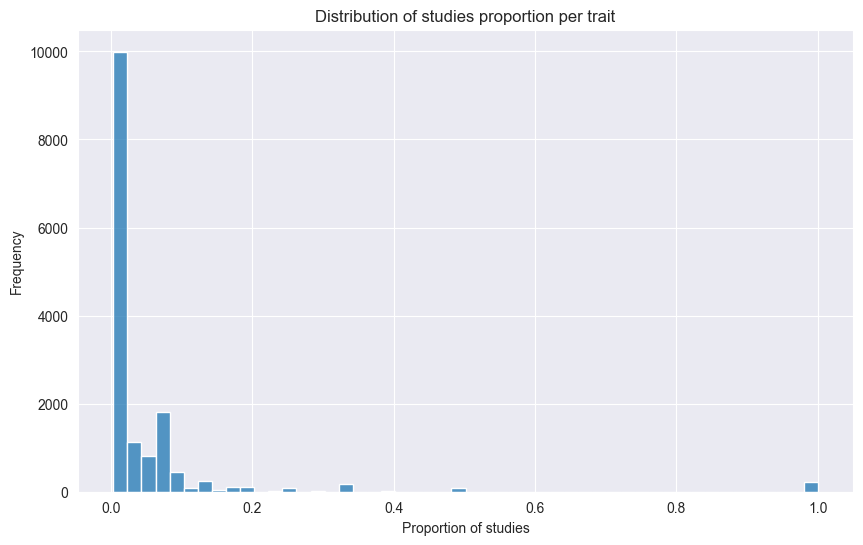

np.int64(218)

In [41]:
# Plot the distribution of the studies proportion per trait
plt.figure(figsize=(10, 6))
sns.histplot(df['prop_studies'].explode(), bins=50, kde=False)
plt.title('Distribution of studies proportion per trait')
plt.xlabel('Proportion of studies')
plt.ylabel('Frequency')
plt.show()

df['prop_studies'].explode().value_counts()[df['prop_studies'].explode().value_counts().index.max()]

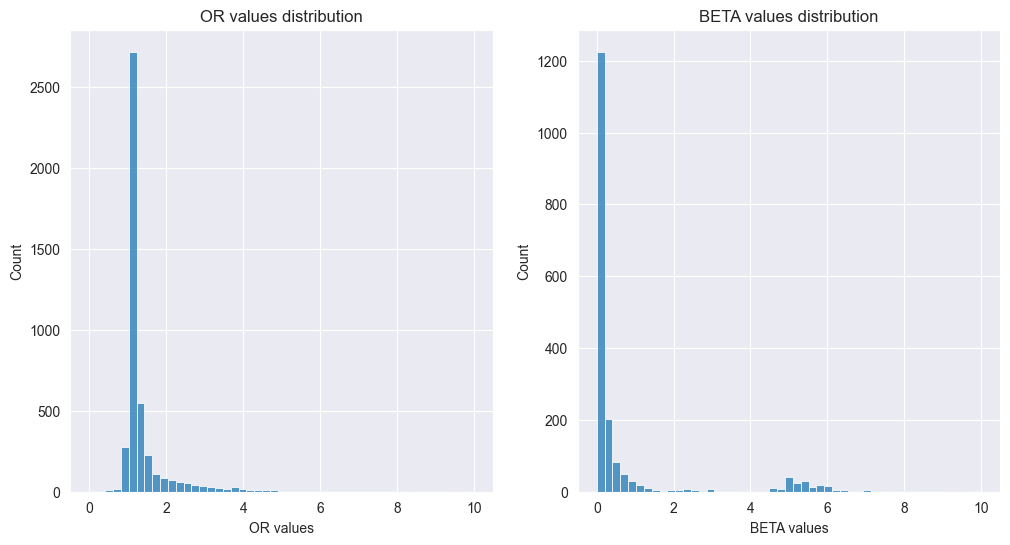

In [10]:
# Plot the general distribution of the OR and BETA values
or_values = df['OR'].explode()
or_values = or_values[or_values > 0]  # Filter out non-positive values
beta_values = df['BETA'].explode()
beta_values = beta_values[(beta_values > 0) & (beta_values < 1000)]  # Filter out non-positive values and values greater than 1000
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
or_bins = np.linspace(0, 10, 50)
sns.histplot(or_values, bins=or_bins, kde=False, ax=ax[0])
ax[0].set_title('OR values distribution')
ax[0].set_xlabel('OR values')
beta_bins = np.linspace(0, 10, 50)
sns.histplot(beta_values, bins=beta_bins, kde=False, ax=ax[1])
ax[1].set_title('BETA values distribution')
ax[1].set_xlabel('BETA values')
plt.savefig('effect_sizes_distribution.png')
plt.show()

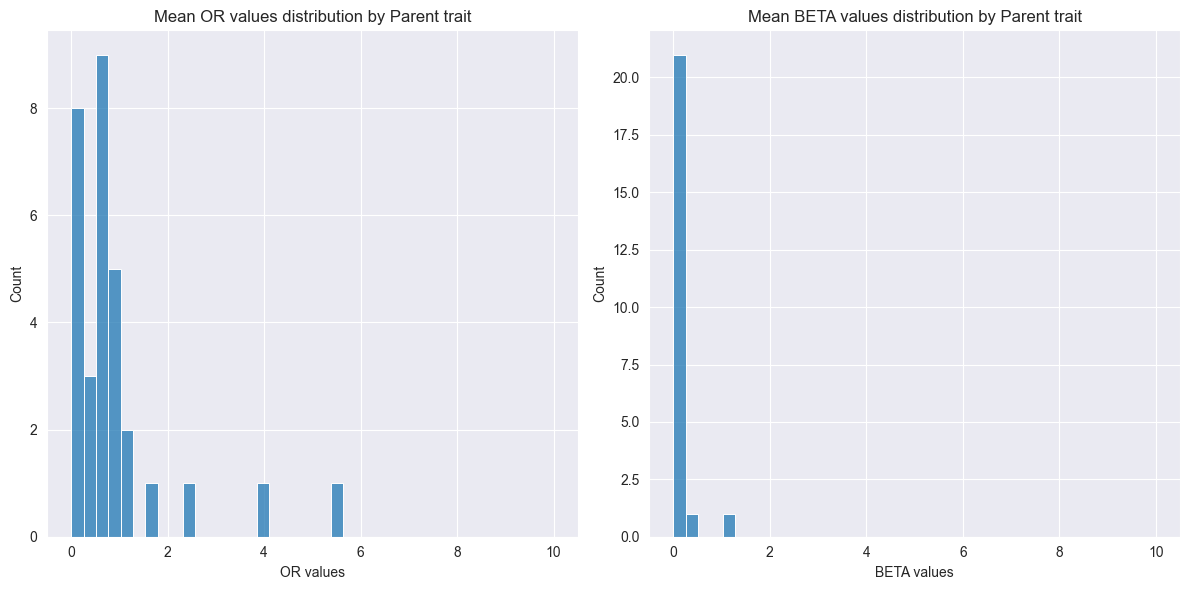

In [11]:
# Plot the distribution of OR and BETA values for each trait

plot_df = df.explode(['OR', 'BETA'])
plot_df['OR'] = pd.to_numeric(plot_df['OR'], errors='coerce')
plot_df['BETA'] = pd.to_numeric(plot_df['BETA'], errors='coerce')


plot_df = plot_df.groupby('Parent_trait').agg({
    'OR': 'mean',
    'BETA': 'mean'
})

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
bins = np.linspace(0, 10, 40)
sns.histplot(plot_df['OR'][plot_df['OR'] > 0], bins=bins, kde=False, ax=ax[0])
ax[0].set_title('Mean OR values distribution by Parent trait')
ax[0].set_xlabel('OR values')

sns.histplot(plot_df['BETA'][plot_df['BETA'] > 0], bins=bins, kde=False, ax=ax[1])
ax[1].set_title('Mean BETA values distribution by Parent trait')
ax[1].set_xlabel('BETA values')
plt.tight_layout()
plt.savefig('mean_effect_sizes_distribution.png')
plt.show()

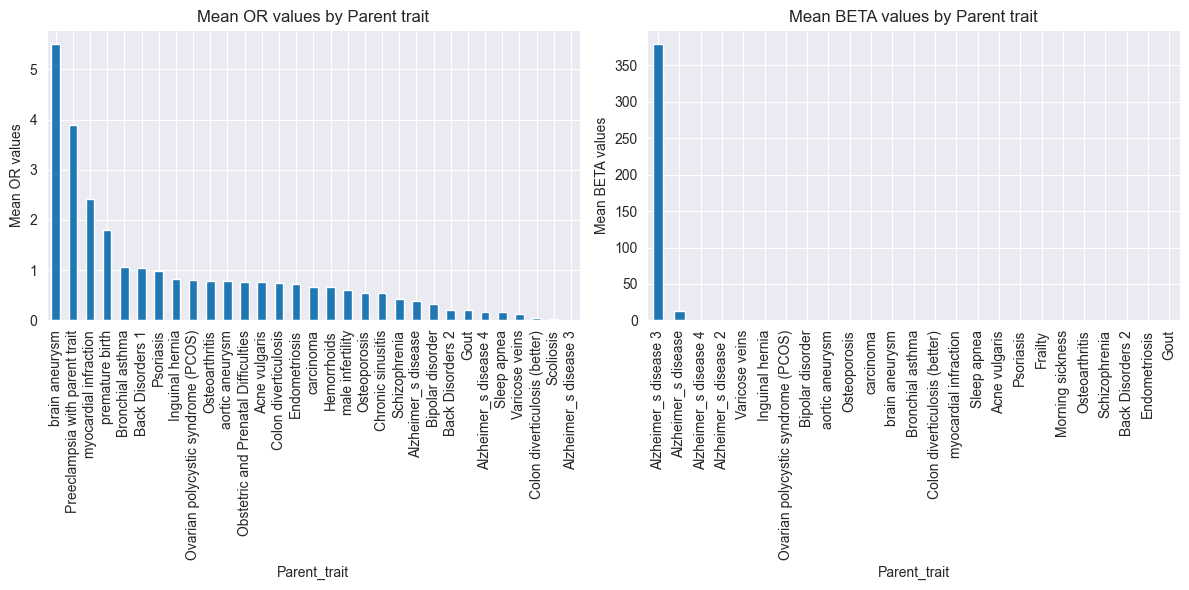

In [12]:
# Bar plot of mean OR and BETA values by Parent trait
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_df = plot_df.sort_values('OR', ascending=False)
plot_df['OR'][plot_df['OR'] > 0].plot(kind='bar', ax=ax[0])
ax[0].set_title('Mean OR values by Parent trait')
ax[0].set_ylabel('Mean OR values')
plot_df = plot_df.sort_values('BETA', ascending=False)
plot_df['BETA'][plot_df['BETA'] > 0].plot(kind='bar', ax=ax[1])
ax[1].set_title('Mean BETA values by Parent trait')
ax[1].set_ylabel('Mean BETA values')
plt.tight_layout()
plt.savefig('highest_effect_sizes.png')
plt.show()

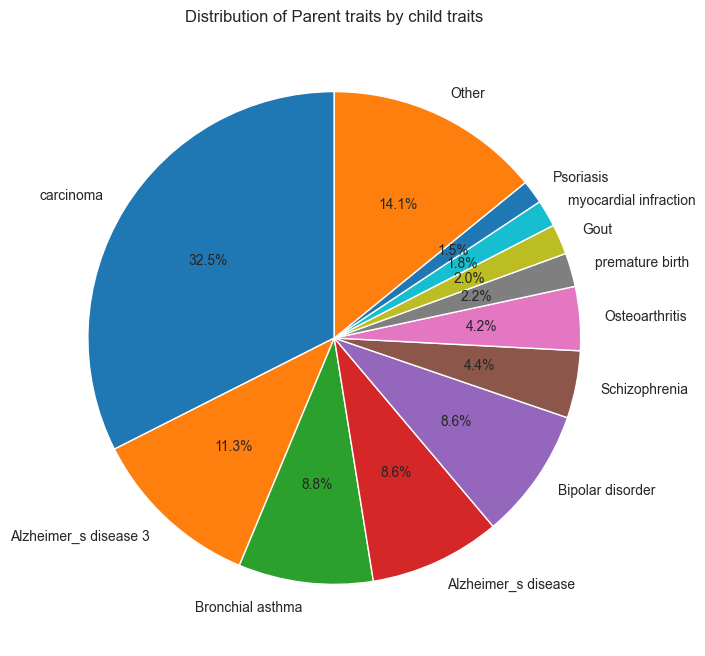

In [13]:
# Pie chart of Parent traits by child traits
trait_counts = df['Parent_trait'].value_counts()
trait_counts = trait_counts[trait_counts > 0]
other_count = trait_counts[trait_counts < 0.015 * len(df)].sum()
trait_counts = trait_counts[trait_counts >= 0.015 * len(df)]
trait_counts['Other'] = other_count
plt.figure(figsize=(13, 8))
trait_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False)
plt.title('Distribution of Parent traits by child traits')
plt.ylabel('')
plt.savefig('child_traits.png')
plt.show()

In [14]:
import bisect

def sort_genes_by_percentiles(
    row,
    count_pct=90.0,   # keep genes whose normalized_counts ≥ the count_pct percentile
    beta_pct=75.0,    # among those kept by count, keep genes whose BETA ≥ the beta_pct percentile
    or_pct=80.0       # among those kept by count, keep genes whose OR ≥ the or_pct percentile
):
    """
    1) Find the count‐value cutoff at the count_pct percentile of row['normalized_counts'].
       Keep genes with counts ≥ that cutoff (binary search).
    2) On that count‐filtered subset, compute:
         - beta_cutoff = percentile(betas, beta_pct)
         - or_cutoff   = percentile(ors, or_pct)
       Keep genes where (BETA ≥ beta_cutoff) OR (OR ≥ or_cutoff).
    3) Sort the survivors by BETA in descending order.
    4) Overwrite row['studies_prop'], row['BETA'], row['OR'], row['MAPPED_GENE'],
       row['REPORTED GENE(S)'] to be only those survivors, in BETA‐sorted order.
    """

    # 0) Shortcut if no genes at all
    counts_desc = row['studies_prop']
    if not counts_desc:
        return row

    # 1) Make sure all five lists have the same length
    betas_list    = row['BETA']
    ors_list      = row['OR']
    mapped_list   = row['MAPPED_GENE']
    reported_list = row['REPORTED GENE(S)']

    L = len(counts_desc)
    if not (len(betas_list) == len(ors_list) == len(mapped_list)):
        # If lengths mismatch, bail out (or handle however you prefer)
        print(f"Length mismatch in row {row.name}:",
              len(counts_desc), len(betas_list),
              len(ors_list), len(mapped_list), len(reported_list))
        return row

    # 2) Compute the absolute cutoff in counts based on count_pct
    #    Because counts_desc is assumed sorted descending, we can do:
    cutoff_count_val = np.percentile(counts_desc, count_pct)

    #    Find how many entries are ≥ cutoff_count_val via binary search on a descending list.
    #    We invert counts to ascend and find the first index where -counts[i] >= -cutoff_count_val
    neg_counts = [-c for c in counts_desc]
    cut_index  = bisect.bisect_left(neg_counts, -cutoff_count_val)
    #    Now, counts_desc[:cut_index] are exactly the genes with counts ≥ cutoff_count_val.
    if cut_index == 0:
        # No gene meets the count cut
        return row

    # 3) Slice all five arrays up to cut_index
    counts         = np.array(counts_desc[:cut_index])
    betas          = np.array(betas_list[:cut_index])
    ors            = np.array(ors_list[:cut_index])
    mapped_genes   = np.array(mapped_list[:cut_index])

    # 4) Among that subset, compute the percentiles for BETA and OR
    beta_cutoff = np.percentile(betas, beta_pct)
    or_cutoff   = np.percentile(ors,  or_pct)

    # 5) Build an effect‐size mask: keep any gene where (BETA ≥ beta_cutoff) OR (OR ≥ or_cutoff).
    effect_mask = (betas >= beta_cutoff) | (ors >= or_cutoff)

    #    Apply that mask
    counts         = counts[effect_mask]
    betas          = betas[effect_mask]
    ors            = ors[effect_mask]
    mapped_genes   = mapped_genes[effect_mask]

    # 6) If nothing remains after effect filtering, return early
    if len(betas) == 0:
        return row

    # 7) Finally, sort the remaining genes by BETA in descending order
    sorted_idx = np.argsort(betas)[::-1]

    row['prop_studies'] = counts[sorted_idx].tolist()
    row['BETA']              = betas[sorted_idx].tolist()
    row['OR']                = ors[sorted_idx].tolist()
    row['MAPPED_GENE']       = mapped_genes[sorted_idx].tolist()
    return row


In [15]:
# Apply the function to the dataframe
df = df.apply(sort_genes_by_percentiles, axis=1)
df.reset_index(drop=True, inplace=True)

df.head(50)

KeyError: 'normalized_counts'

In [ ]:
# Sanity check- if the length of mapped genes and effect sizes are the same
for index, row in df.iterrows():
    if len(row['MAPPED_GENE']) != len(row['normalized_counts']):
        print(f"Mismatch at index {index}: {len(row['MAPPED_GENE'])} genes vs {len(row['normalized_counts'])} counts")
    if len(row['MAPPED_GENE']) != len(row['BETA']):
        print(f"Mismatch at index {index}: {len(row['MAPPED_GENE'])} genes vs {len(row['BETA'])} BETA values")
    if len(row['MAPPED_GENE']) != len(row['OR']):
        print(f"Mismatch at index {index}: {len(row['MAPPED_GENE'])} genes vs {len(row['OR'])} OR values")

In [ ]:
# Save the final dataframe to an Excel file
df.to_excel('/Users/gilsasson/Data Science Project/GWAS/traits_filtered.xlsx', index=False)

In [49]:
from pycirclize import Circos
import numpy as np
import pandas as pd

# 1. compute Spearman correlations
cors = df[predictors].corrwith(df[sleep_metric], method="spearman")

# 2. set up sectors
sectors = {pred: category_map[pred] for pred in predictors}

circos = Circos(sectors=sectors.values())
# 3. add a heatmap track
heatmap = circos.add_track(
    track_type="heatmap", r0=0.5, r1=0.8
)
# 4. assign values and colors
heatmap.values = [cors[pred] for pred in predictors]
heatmap.color_map = lambda v: plt.cm.RdBu_r((v + 0.6) / 1.2)
# 5. draw labels and legend
circos.plot()


['Gene\tindex\tChromosome\tStart(hg38)\tEnd(hg38)\tStart(hg19)\tEnd(hg19)\tStrand\tID(ENTREZ)\tGene type\tTSS\tID(Ensemble)\t0_Fibroblast_LFC_human_ref\t0_Fibroblast_LFC_padj_human_ref\t0_Fibroblast_LFC_chimp_ref\t0_Fibroblast_LFC_padj_chimp_ref\t0_Fibroblast_TPM_total\t0_Fibroblast_TPM_human_allele\t0_Fibroblast_TPM_chimp_allele\t1_Fibroblast_LFC_human_ref\t1_Fibroblast_LFC_padj_human_ref\t1_Fibroblast_LFC_chimp_ref\t1_Fibroblast_LFC_padj_chimp_ref\t1_Fibroblast_TPM_total\t1_Fibroblast_TPM_human_allele\t1_Fibroblast_TPM_chimp_allele\t2_Mesenchyme_LFC_human_ref\t2_Mesenchyme_LFC_padj_human_ref\t2_Mesenchyme_LFC_chimp_ref\t2_Mesenchyme_LFC_padj_chimp_ref\t2_Mesenchyme_TPM_total\t2_Mesenchyme_TPM_human_allele\t2_Mesenchyme_TPM_chimp_allele\t3_Fibroblast_LFC_human_ref\t3_Fibroblast_LFC_padj_human_ref\t3_Fibroblast_LFC_chimp_ref\t3_Fibroblast_LFC_padj_chimp_ref\t3_Fibroblast_TPM_total\t3_Fibroblast_TPM_human_allele\t3_Fibroblast_TPM_chimp_allele\t4_Prechondral_Mesenchyme_LFC_human_ref\t4_P